<a href="https://colab.research.google.com/github/naoya1110/ai_robotics_lab_2023_hands_on/blob/main/Week05_Convolutional_Neural_Network_with_CIFAR10_Dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# NCKU-NITKC AI Robotics Lab - Week 05

## Introduction

In this notebook, we will learn about:

* Convolutional Neural Networks (CNNs)
* Conv2D Layer
* MaxPooling 2D Layer

Last week, we implemented a simple MLP model for classifying three different iris species based on their four feature values. The model we used was made of simple linear layers. While such models can be applied to image recognition tasks, they are not very efficient.

On the other hand, CNNs are better suited for image recognition tasks. The invention of CNNs has significantly improved the accuracy of image recognition AI, surpassing human performance levels. Nowadays, most modern image recognition AI systems rely on CNNs.

We will build a simple CNN model and train it using the CIFAR10 dataset. The CIFAR10 dataset comprises 10 categories of 32x32 pixel color images, as shown below:

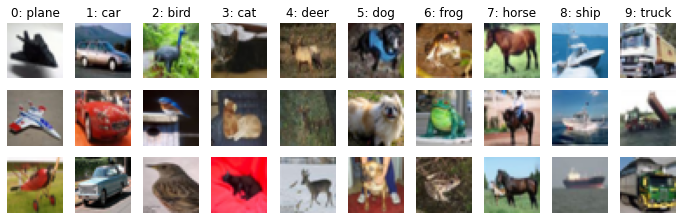

### GPU

To train CNN models, a GPU is required. Please ensure that your runtime type is set to GPU.

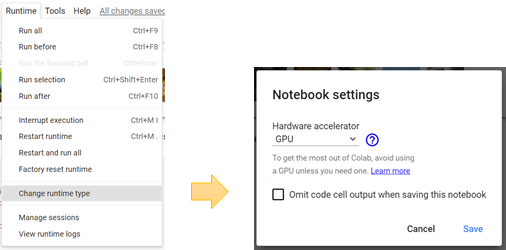

We can check if we have access to the GPU (cuda).

In [ ]:
import torch

if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"

print(device)

### Import Packages

Let's import some general Python packages.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm

## Data Preparation

### CIFAR10 Dataset

The CIFAR10 dataset can be loaded from `torchvision.datasets`. The `torchvision` package includes various popular datasets, model architectures, and common image transformations for computer vision tasks.

*   CIFAR10 https://www.cs.toronto.edu/~kriz/cifar.html
* torchvison https://pytorch.org/vision/stable/index.html

In [ ]:
from torchvision.datasets import CIFAR10

train_dataset = CIFAR10(root="cifar10", train=True, download=True)
test_dataset = CIFAR10(root="cifar10", train=False, download=True)

The CIFAR10 dataset consists of 50,000 labeled images for training and 10,000 for testing.

In [ ]:
print("train dataset", len(train_dataset))
print("test dataset", len(test_dataset))

We can access individual sets of images and labels by indexing the dataset. The image data is in PIL format and can be visualized using Matplotlib.

* PIL(Pillow) https://pillow.readthedocs.io/en/latest/handbook/index.html

In [ ]:
image, label = train_dataset[0]

print("type of image:", type(image))
print("size of image:", image.size)
print("label:", label)

plt.figure(figsize=(5,3))
plt.imshow(image)
plt.title(label)

The label number corresponds to the 10 categories of the images, as shown below.

In [ ]:
classnames = {0:"plane",
              1:"car",
              2:"bird",
              3:"cat",
              4:"deer",
              5:"dog",
              6:"frog",
              7:"horse",
              8:"ship",
              9:"truck"}

classnames

### torch.tensor

To work with data in PyTorch, it needs to be in the `torch.tensor` format. You can get the data in `torch.tensor` format by specifying the `transform=transforms.ToTensor()` parameter when loading it from `torchvision.datasets`.

In [15]:
from torchvision import transforms

train_dataset = CIFAR10(root="cifar10", train=True, download=False, transform=transforms.ToTensor())
test_dataset = CIFAR10(root="cifar10", train=False, download=False, transform=transforms.ToTensor())

Now the image data is in `torch.tensor`.

In [16]:
image, label = train_dataset[0]
print(type(image))

<class 'torch.Tensor'>


**Important:** One of the differences between `PIL` and `torch.tensor` image data is the order of their data shape, as shown below.

|  data format  |  shape  |
| :----: | :----: |
|  PIL  |  (32, 32, 3)  <br> (height, width, channel)|
|  torch.tensor  |  (3, 32, 32)  <br> (channel, height, width)|


The image data with the shape of (3, 32, 32) cannot be directly visualized using matplotlib.


In [ ]:
plt.figure(figsize=(5,3))
plt.imshow(image)    # this raises an error

### DataLoader

We create `DataLoader` objects to feed the dataset into a PyTorch model, just as we did with the Iris dataset.

In [19]:
from torch.utils.data import DataLoader

train_loader = DataLoader(train_dataset, batch_size=50, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=50, shuffle=False)

That's it for data preparation!

## Model Building

### Model Architecture

The next step is to build a Convolutional Neural Network (CNN). The model we will create consists of two parts: "features" and "classifier". The "features" part includes `Conv2D` (2D convolution) layers with `ReLU` activation functions and `MaxPool2D` layers. The "classifier" part consists of `Linear` layers with `ReLU` activation functions.

The "features" part is responsible for extracting features from the input image, and the `flatten` layer converts these features into 1D data. Then, the "classifier" part is used to classify the image based on the extracted features.

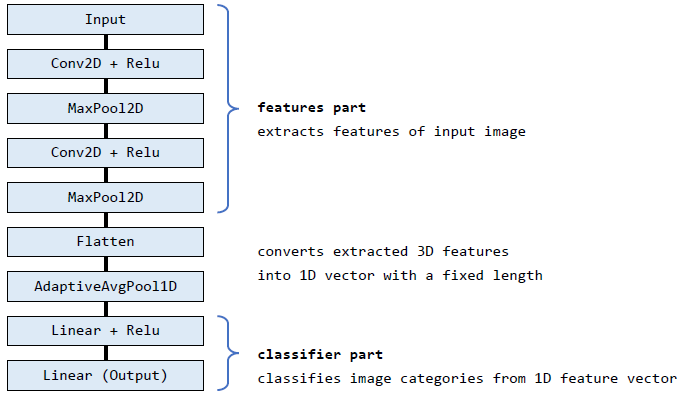

In [ ]:
import torch.nn as nn

# define a class named "Model"
class Model(nn.Module):

    # Constructor
    def __init__(self):                 # do not change
        super(Model, self).__init__()   # do not change

        # define a network module named "features"
        self.features = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )

        # define a network module named "junction"
        self.junction = nn.Sequential(
            nn.Flatten(),
            nn.AdaptiveAvgPool1d(output_size=512)
        )

        # define a network module named "classifier"
        self.classifier = nn.Sequential(
            nn.Linear(in_features=512, out_features=256),
            nn.ReLU(),
            nn.Linear(in_features=256, out_features=10)
        )

    # Instance method
    def forward(self, x):   # do not change
        x = self.features(x)
        x = self.junction(x)
        x = self.classifier(x)
        return x

model = Model()    # construct an instance of the Model class
print(model)

Then, we load the model onto the GPU.

In [25]:
model = model.to(device)

Let's visualize the model architecture using the torchinfo package. This is a valuable tool for understanding how the data shape evolves as it moves through the model.

In [ ]:
! pip install torchinfo
from torchinfo import summary

for x_batch, _ in train_loader:
    break

input_shape = x_batch.shape
print("\ninput data shape:", input_shape)

summary(model, input_shape)

### Conv2D Layer

The `nn.Conv2D` layer generates output data by performing convolution, which involves calculating the sum of element-wise products between the input data and the filters (also known as kernels). The size of the filters is typically smaller than the input data, and these filters are moved across the entire input data. In a Conv2D layer, multiple different filters are often used, resulting in several distinct output data channels. The values within the filters are the trainable parameters, and these values are updated during the training process.

https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html

#### Example-1

`nn.Conv2d(in_channels=1, out_channels=1, kernel_size=3, padding=0)`
*   Input data is a grayscale image with the size of (1x6x6), therefore `in_channels=1`
*   Use only one filter with the size of (1x3x3), therefore `out_channels=1`, `kernel_size=3`
*   No paddings are applied, therefore `padding=0`



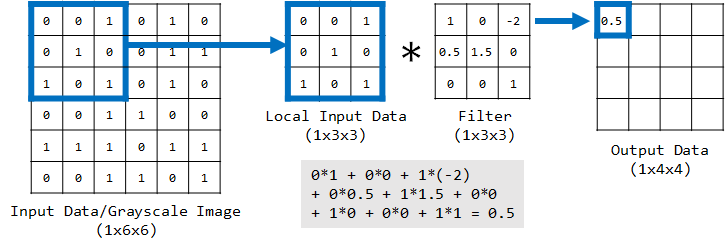

#### Example-2

`nn.Conv2d(in_channels=3, out_channels=1, kernel_size=3, padding=0)`
*   Input data is a color image with the size of (3x6x6), therefore `in_channels=3`
*   Use only 1 filter with the size of (3x3x3), therefore `out_channels=1`, `kernel_size=3`
*   No paddings are applied, therefore `padding=0`


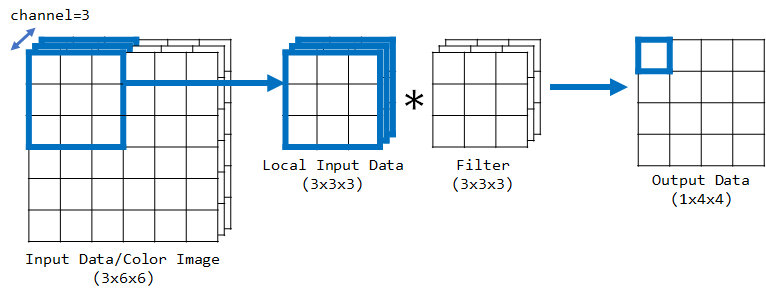

#### Example-3
`nn.Conv2d(in_channels=3, out_channels=5, kernel_size=3, padding=0)`
*   Input data is a color image with the size of (3x6x6), therefore `in_channels=1`
*   Use 5 filters with the size of (3x3x3), therefore `out_channels=5`, `kernel_size=3`
*   No paddings are applied, therefore `padding=0`

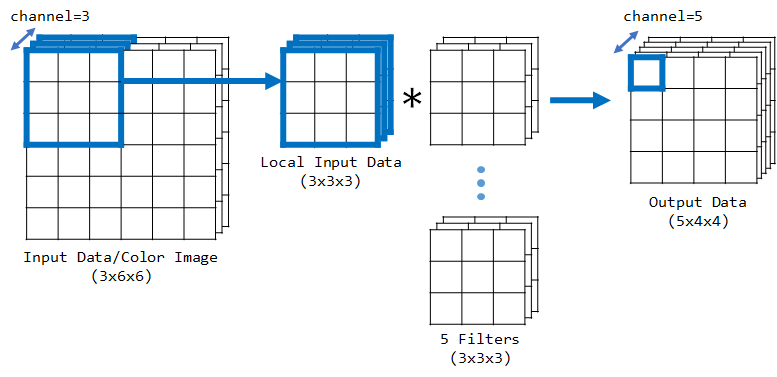

#### Example-4
`nn.Conv2d(in_channels=5, out_channels=10, kernel_size=3, padding=1)`
*   Input data is the output data of Example-3 (5x4x4), therefore `in_channels=5`
*   Use 10 filters with kernel size of (5x3x3), therefore `out_channels=5`, `kernel_size=3`
*   Paddings are applied to all 4 sides, therefore `padding=1`

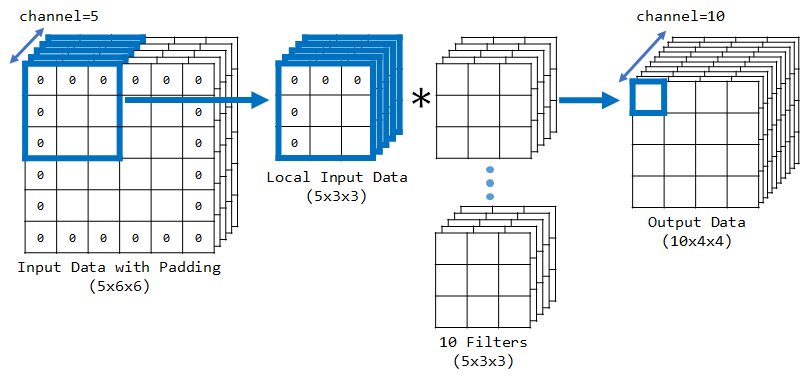

You can play with the code below to observe how the Conv2D layer functions.

In [ ]:
# input image (10x10) --- do not change
input_img = torch.tensor([0,0,1,0,0,0,0,1,0,0,
                          0,1,0,1,0,0,1,0,1,0,
                          0,1,0,0,1,1,0,0,1,0,
                          1,0,0,0,0,0,0,0,0,1,
                          1,0,0,1,0,0,1,0,0,1,
                          0,0,0,1,0,0,1,0,0,0,
                          0,0,0,0,0,0,0,0,0,0,
                          1,0,1,0,1,1,0,1,0,1,
                          1,0,0,1,0,0,1,0,0,1,
                          0,1,0,0,0,0,0,0,1,0], dtype=torch.float32)
input_img = input_img.view(1, 1, 10, 10)

# define a Conv2d layer
conv = nn.Conv2d(in_channels=1,
                 out_channels=1,
                 kernel_size=3,
                 padding=1,
                 bias=False)

# set weights of the Conv2D layer
weights = (torch.tensor([[1, 0, 0],
                         [0, 1, 0],
                         [0, 0, 1]]).view(1, 1, 3, 3).float()
                         )
conv.weight = nn.Parameter(weights)

# Execute convolutional operation
conv_img = conv(input_img)

# Visualize input image, filter and output image
plt.figure(figsize=(15,4))

plt.subplot(1,3,1)
sns.heatmap(torch.squeeze(input_img).numpy(), annot=True, square=True, cmap="Blues")
plt.title(f"Input Image")

plt.subplot(1,3,2)
sns.heatmap(torch.squeeze(weights).numpy(), annot=True, square=True, cmap="Blues")
plt.title(f"Filter")

plt.subplot(1,3,3)
sns.heatmap(torch.squeeze(conv_img).detach().numpy(), annot=True, square=True, cmap="Blues")
plt.title(f"Convoluted Image")

### MaxPool2D Layer

The `nn.MaxPool2D` layer creates down-sampled output images by selecting the maximum value within a specified partial area of the input images.

https://pytorch.org/docs/stable/generated/torch.nn.MaxPool2d.html

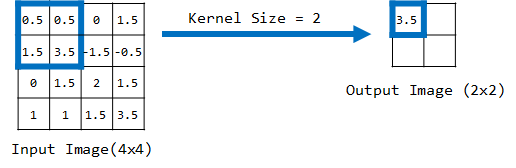

In [ ]:
# Define a MaxPool2d Layer
max_pool = nn.MaxPool2d(kernel_size=2, stride=None, padding=0)

# Execute pooling
pool_img = max_pool(conv_img)

# visualize input and output data
plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
sns.heatmap(torch.squeeze(conv_img).detach().numpy(), annot=True, square=True, cmap="Blues")
plt.title("Input Image")

plt.subplot(1,2,2)
sns.heatmap(torch.squeeze(pool_img).detach().numpy(), annot=True, square=True, cmap="Blues")
plt.title("Pooled Image")

### Flatten

The `nn.Flatten` layer reshapes multi-dimentional data into 1D data.

https://pytorch.org/docs/stable/generated/torch.nn.Flatten.html

In [ ]:
x = np.random.randint(0, 3, 18).reshape((2,3,3))
x = torch.tensor([x], dtype=torch.float32)

print("Before")
print(x)
flatten = nn.Flatten()
x = flatten(x)
print("After")
print(x)

### AdaptiveAvgPool1D

The `nn.AdaptiveAvgPool1d` layer performs average pooling on 1D input data, producing 1D output data with a fixed size.

In [30]:
x = np.random.randint(0, 3, 10)
x = torch.tensor([x], dtype=torch.float32)

aap1 = nn.AdaptiveAvgPool1d(output_size=3)
aap2 = nn.AdaptiveAvgPool1d(output_size=5)

x1 = aap1(x)
x2 = aap2(x)

print("Before")
print(x)
print("After aap1")
print(x1)
print("After aap2")
print(x2)

Before
tensor([[2., 2., 1., 1., 2., 0., 0., 1., 0., 0.]])
After aap1
tensor([[1.5000, 0.7500, 0.2500]])
After aap2
tensor([[2.0000, 1.0000, 1.0000, 0.5000, 0.0000]])


## Training

### Loss Function

We use the cross-entropy loss as the loss function because this is a classification task.

In [31]:
loss_func = nn.CrossEntropyLoss()

### Optimizer

We use the Adam optimizer.

In [32]:
import torch.optim as optim

optimizer = optim.Adam(model.parameters(), lr=1E-3)

### Training Loop
Now, we will train the model using the CIFAR10 dataset. The training loop is similar to what we covered last week, with the key difference being that we load both the dataset and the model onto the GPU.







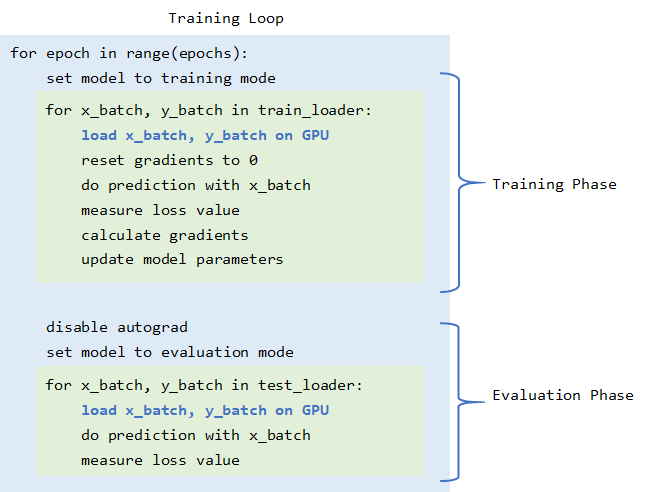

In [44]:
model = Model().to(device)                             # load model to GPU
loss_func = nn.CrossEntropyLoss()                      # set loss function
optimizer = optim.Adam(model.parameters(), lr=1E-3)    # set optimizer

epochs = 30

# create empty lists for saving metrics during training
train_loss_list = []
train_accuracy_list = []
test_loss_list = []
test_accuracy_list = []

for epoch in range(epochs):
    print("-----------------------------")
    print(f"Epoch {epoch+1}/{epochs}")

    # initialize metrics
    train_correct_count = 0
    train_accuracy = 0
    train_loss = 0
    test_correct_count = 0
    test_accuracy = 0
    test_loss = 0

    #--- Training Phase ---#
    model.train()    # set model to training mode

    for x_batch, y_batch in tqdm(train_loader): # take mini batch data from train_loader

        x_batch = x_batch.to(device)     # load x_batch data on GPU
        y_batch = y_batch.to(device)     # load y_batch data on GPU

        optimizer.zero_grad()                  # reset gradients to 0
        p_batch = model(x_batch)               # do prediction
        loss = loss_func(p_batch, y_batch)     # measure loss
        loss.backward()                        # calculate gradients
        optimizer.step()                       # update model parameters

        train_loss += loss.item()                                # accumulate loss value
        p_batch_label = torch.argmax(p_batch, dim=1)             # convert p_batch vector to p_batch_label
        train_correct_count += (p_batch_label == y_batch).sum()  # count up number of correct predictions
    #----------------------#

    #--- Evaluation Phase ---#
    with torch.no_grad():   # disable autograd for saving memory usage
        model.eval()        # set model to evaluation mode

        for x_batch, y_batch in tqdm(test_loader):   # take mini batch data from test_loader

            x_batch = x_batch.to(device)     # load x_batch data on GPU
            y_batch = y_batch.to(device)     # load y_batch data on GPU

            p_batch = model(x_batch)              # do prediction
            loss = loss_func(p_batch, y_batch)    # measure loss

            test_loss += loss.item()                                # accumulate loss value
            p_batch_label = torch.argmax(p_batch, dim=1)            # convert p_batch vector to p_batch_label
            test_correct_count += (p_batch_label == y_batch).sum()  # count up number of correct predictions
    #------------------------#

    train_accuracy = train_correct_count/len(train_dataset)   # determine accuracy for training data
    test_accuracy = test_correct_count/len(test_dataset)      # determine accuracy for test data
    train_loss = train_loss/len(train_loader)                 # determine loss for training data
    test_loss = test_loss/len(test_loader)                    # determine loss for test data

    # show and store metrics
    print(f"Train: Accuracy={train_accuracy:.3f} Loss={train_loss:.3f}, Test: Accuracy={test_accuracy:.3f} Loss={test_loss:.3f}")
    train_accuracy_list.append(train_accuracy.item())
    train_loss_list.append(train_loss)
    test_accuracy_list.append(test_accuracy.item())
    test_loss_list.append(test_loss)

-----------------------------
Epoch 1/30


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Train: Accuracy=0.398 Loss=1.643, Test: Accuracy=0.479 Loss=1.424
-----------------------------
Epoch 2/30


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Train: Accuracy=0.512 Loss=1.346, Test: Accuracy=0.550 Loss=1.252
-----------------------------
Epoch 3/30


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Train: Accuracy=0.567 Loss=1.207, Test: Accuracy=0.576 Loss=1.169
-----------------------------
Epoch 4/30


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Train: Accuracy=0.605 Loss=1.110, Test: Accuracy=0.624 Loss=1.061
-----------------------------
Epoch 5/30


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Train: Accuracy=0.633 Loss=1.031, Test: Accuracy=0.639 Loss=1.026
-----------------------------
Epoch 6/30


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Train: Accuracy=0.657 Loss=0.972, Test: Accuracy=0.658 Loss=0.972
-----------------------------
Epoch 7/30


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Train: Accuracy=0.673 Loss=0.919, Test: Accuracy=0.671 Loss=0.923
-----------------------------
Epoch 8/30


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Train: Accuracy=0.690 Loss=0.877, Test: Accuracy=0.688 Loss=0.893
-----------------------------
Epoch 9/30


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Train: Accuracy=0.703 Loss=0.840, Test: Accuracy=0.676 Loss=0.921
-----------------------------
Epoch 10/30


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Train: Accuracy=0.716 Loss=0.805, Test: Accuracy=0.707 Loss=0.853
-----------------------------
Epoch 11/30


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Train: Accuracy=0.726 Loss=0.776, Test: Accuracy=0.694 Loss=0.873
-----------------------------
Epoch 12/30


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Train: Accuracy=0.736 Loss=0.750, Test: Accuracy=0.702 Loss=0.851
-----------------------------
Epoch 13/30


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Train: Accuracy=0.744 Loss=0.723, Test: Accuracy=0.715 Loss=0.826
-----------------------------
Epoch 14/30


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Train: Accuracy=0.752 Loss=0.702, Test: Accuracy=0.722 Loss=0.812
-----------------------------
Epoch 15/30


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Train: Accuracy=0.762 Loss=0.677, Test: Accuracy=0.721 Loss=0.800
-----------------------------
Epoch 16/30


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Train: Accuracy=0.768 Loss=0.660, Test: Accuracy=0.726 Loss=0.789
-----------------------------
Epoch 17/30


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Train: Accuracy=0.773 Loss=0.639, Test: Accuracy=0.724 Loss=0.810
-----------------------------
Epoch 18/30


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Train: Accuracy=0.779 Loss=0.621, Test: Accuracy=0.739 Loss=0.762
-----------------------------
Epoch 19/30


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Train: Accuracy=0.786 Loss=0.604, Test: Accuracy=0.739 Loss=0.775
-----------------------------
Epoch 20/30


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Train: Accuracy=0.793 Loss=0.586, Test: Accuracy=0.739 Loss=0.772
-----------------------------
Epoch 21/30


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Train: Accuracy=0.800 Loss=0.570, Test: Accuracy=0.741 Loss=0.777
-----------------------------
Epoch 22/30


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Train: Accuracy=0.805 Loss=0.557, Test: Accuracy=0.745 Loss=0.755
-----------------------------
Epoch 23/30


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Train: Accuracy=0.809 Loss=0.540, Test: Accuracy=0.744 Loss=0.751
-----------------------------
Epoch 24/30


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Train: Accuracy=0.814 Loss=0.524, Test: Accuracy=0.746 Loss=0.776
-----------------------------
Epoch 25/30


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Train: Accuracy=0.818 Loss=0.511, Test: Accuracy=0.740 Loss=0.785
-----------------------------
Epoch 26/30


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Train: Accuracy=0.824 Loss=0.497, Test: Accuracy=0.744 Loss=0.785
-----------------------------
Epoch 27/30


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Train: Accuracy=0.828 Loss=0.484, Test: Accuracy=0.737 Loss=0.788
-----------------------------
Epoch 28/30


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Train: Accuracy=0.833 Loss=0.470, Test: Accuracy=0.736 Loss=0.823
-----------------------------
Epoch 29/30


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Train: Accuracy=0.836 Loss=0.456, Test: Accuracy=0.745 Loss=0.775
-----------------------------
Epoch 30/30


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Train: Accuracy=0.841 Loss=0.446, Test: Accuracy=0.750 Loss=0.761


### Learning Curves

Let's plot the accuracy curves for both the training and test data.

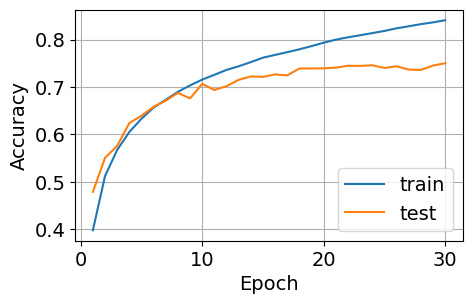

In [45]:
plt.figure(figsize=(5,3))
plt.rcParams["font.size"]=14
plt.plot(np.arange(epochs)+1, train_accuracy_list, label="train")
plt.plot(np.arange(epochs)+1, test_accuracy_list, label="test")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid()
plt.legend()

Also let's plot the loss curves for the training and test data.

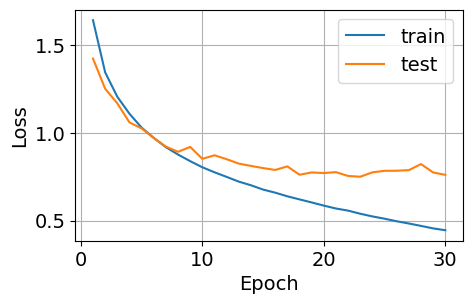

In [46]:
plt.figure(figsize=(5,3))
plt.plot(np.arange(epochs)+1, train_loss_list, label="train")
plt.plot(np.arange(epochs)+1, test_loss_list, label="test")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid()
plt.legend()

### Overfit

You might have noticed that the test accuracy plateaus after the first few epochs, while the training accuracy continues to improve. Additionally, the test loss stops decreasing and starts to increase, whereas the training loss keeps decreasing.

This behavior indicates that the model is being over-trained on the training dataset, meaning it can predict the training data very well but struggles with new, unseen data, including the test dataset. This phenomenon is known as overfitting.

In general, deep neural network models are often prone to overfit due to their large number of trainable parameters. Such models can essentially memorize the training data rather than learning general features.

However, there are several techniques available today to help prevent overfitting in models. We will explore these techniques in the next week.

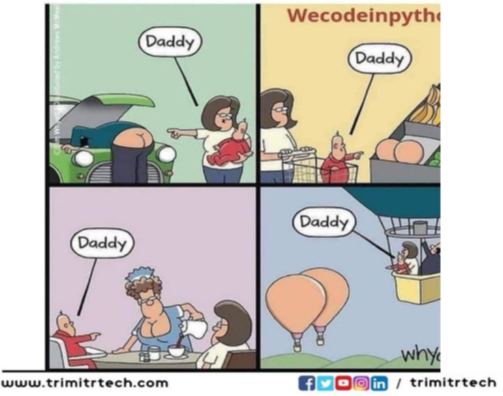

## Evaluation

### Test Accuracy

Let's check the accuracy of the model for all of the test data.

In [47]:
test_accuracy = 0

y_test_all = np.array([])
p_label_all = np.array([])

with torch.no_grad():    # disable autograd
    model.eval()         # set model to evaluation mode

    for x_batch, y_batch in test_loader:    # take mini batch data from train_loader
        x_batch = x_batch.to(device)        # transfer x_batch to gpu
        y_batch = y_batch.to(device)        # transfer y_batch to gpu
        p_batch = model(x_batch)            # do prediction

        p_batch_label = torch.argmax(p_batch, dim=1)       # convert p_batch vector to p_batch_label
        test_accuracy += (p_batch_label == y_batch).sum()  # count up number of correct predictions

        y_test_all = np.append(y_test_all, y_batch.to("cpu").numpy())          # append y_batch in y_test_all
        p_label_all = np.append(p_label_all, p_batch_label.to("cpu").numpy())  # append p_batch_label in p_label_all

test_accuracy = test_accuracy/len(test_dataset)      # determine accuracy for test data
print(f"Test Accuracy = {test_accuracy:.3f}")

Test Accuracy = 0.750


### Confusion Matrix

Then let's check the confusion matrix.

Text(0.5, 1.0, 'confusion matrix')

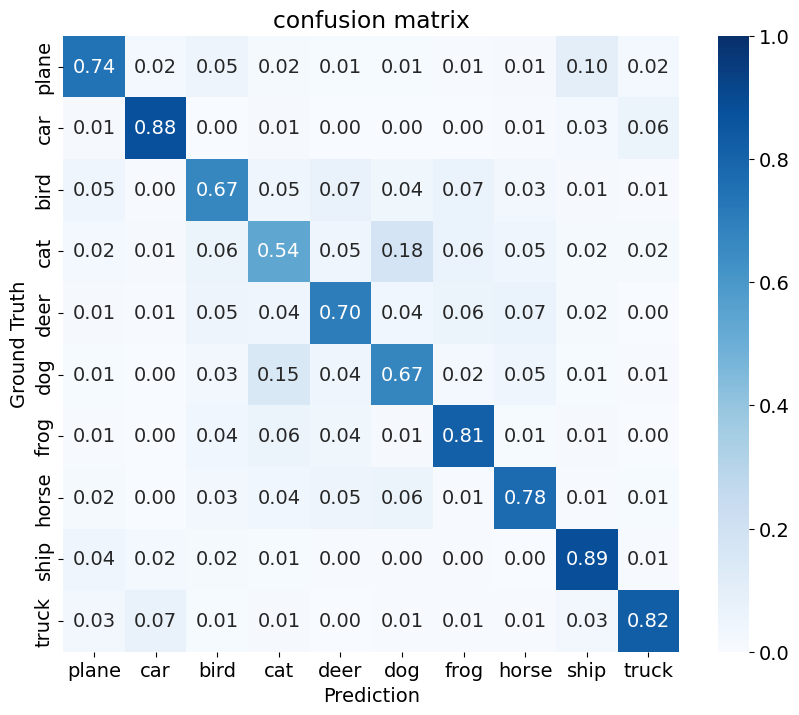

In [51]:
from sklearn.metrics import confusion_matrix

cmx = confusion_matrix(y_test_all, p_label_all)

cmx_pct = np.zeros(cmx.shape)

for i in range(cmx.shape[0]):
    for j in range(cmx.shape[1]):
        cmx_pct[i, j] = cmx[i, j]/cmx[i, :].sum()

plt.figure(figsize=(10,8))
labels = classnames.values()

sns.heatmap(cmx_pct, annot=True, fmt=".2f", cmap="Blues", vmin=0, vmax=1,
            xticklabels=classnames.values(), yticklabels=classnames.values(), square=True)

plt.ylabel("Ground Truth")
plt.xlabel("Prediction")
plt.title("confusion matrix")

### Predictions for Test Data

Let's see predictions for some test data.

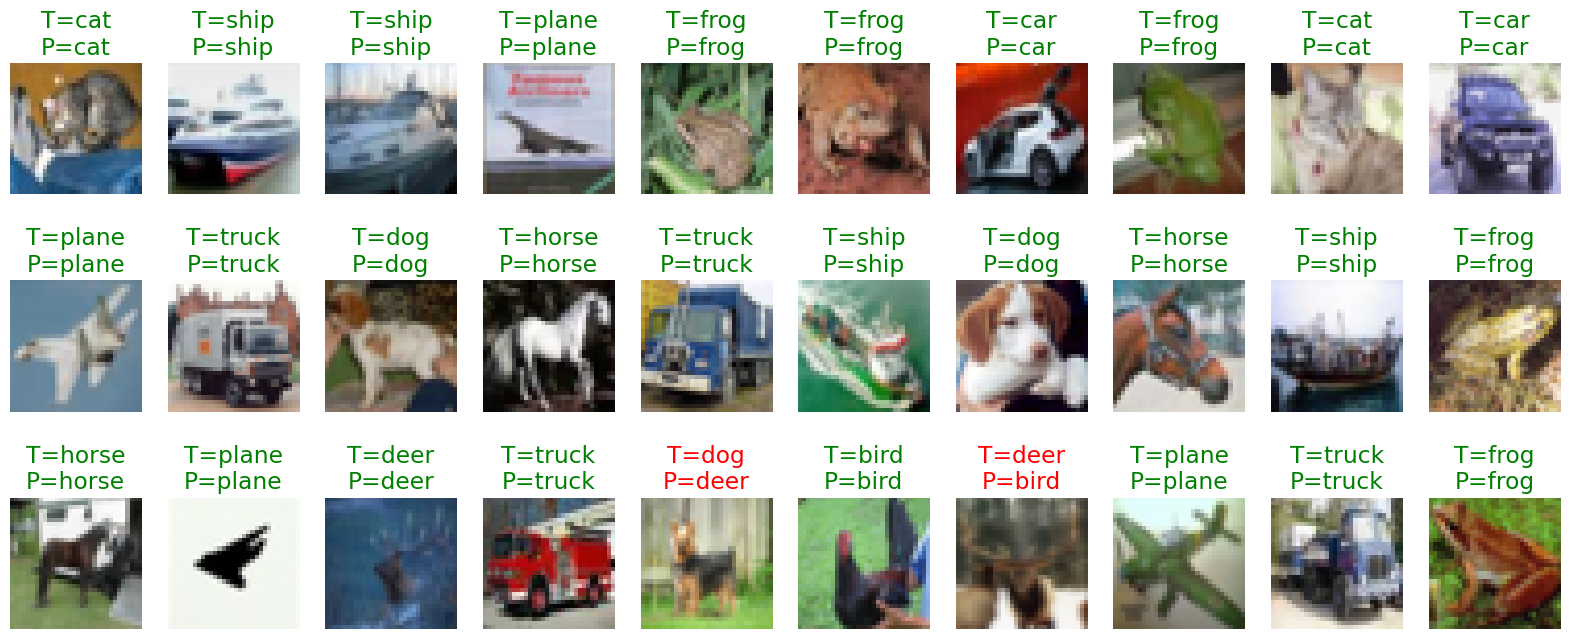

In [52]:
plt.figure(figsize=(20, 8))

for i in range(30):
    image, _ = test_dataset[i]
    image = np.transpose(image, (1,2,0))
    plt.subplot(3, 10, i+1)
    plt.imshow(image)

    true_class = classnames[y_test_all[i]]
    pred_class = classnames[p_label_all[i]]
    if true_class == pred_class:
        color = "green"
    else:
        color = "red"
    plt.title(f"T={true_class}\nP={pred_class}", color=color)
    plt.axis("off")


## Practice

Modify the model as shown below, and train it again.

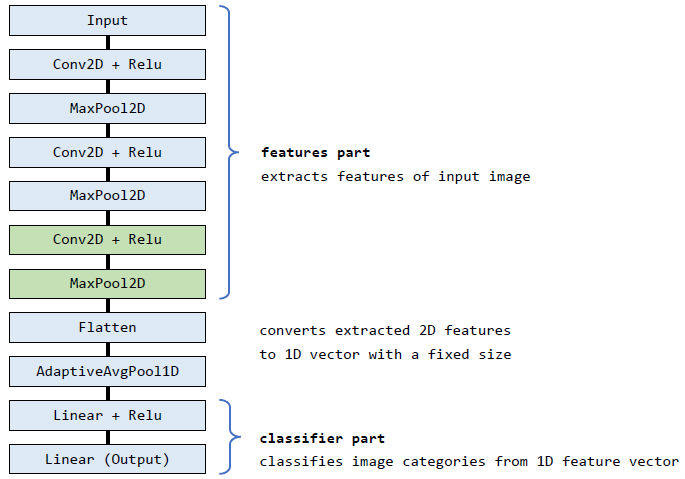

## Conclusion
That's it for this week. Now you can try to improve the test accuracy by changing hyper parameters.